# Change Scenario here.

|     | GameType | HeightNorm | ArmNorm |
|:---:|:--------:|:----------:|:-------:|
| SYY |  Sorting |      ✅     |    ✅    |
| SYN |  Sorting |      ✅     |    ❌    |
| SNY |  Sorting |      ❌     |    ✅    |
| SNN |  Sorting |      ❌     |    ❌    |
| JYY |   Jenga  |      ✅     |    ✅    |
| JYN |   Jenga  |      ✅     |    ❌    |
| JNY |   Jenga  |      ❌     |    ✅    |
| JNN |   Jenga  |      ❌     |    ❌    |

Weights for the corresponding scenario are loaded automatically.

In [1]:
# Possibilities: 'SYY', 'SYN', 'SNY', 'SNN', 
#                'JYY', 'JYN', 'JNY', 'JNN'
cenario = 'SYN'

## Constants

In [2]:
import os

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'  # this is required
os.environ['CUDA_VISIBLE_DEVICES'] = '2'         # set to '0' for GPU0, '1' for GPU1 or '2' for GPU2. Check "gpustat" in a terminal.

In [3]:
import pandas as pd

glob_path = '/opt/iui-datarelease3-sose2021/*.csv'

pickle_file = '../data.pickle'

pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Config

In [4]:
create_new = False
checkpoint_path = f"training_{cenario}/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

win_sz = 5
stride_sz = 1

epoch = 50

# divisor for neuron count step downs (hard to describe), e.g. dense_step = 3: layer1=900, layer2 = 300, layer3 = 100, layer4 = 33...
dense_steps = 3
# amount of dense/dropout layers
layer_count = 3
# how much to drop
drop_count = 0.1

# Helper Functions

In [5]:
from matplotlib import pyplot as plt

def pplot(dd):
    x = dd.shape[0]
    fix = int(x/3)+1
    fiy = 3
    fig, axs = plt.subplots(fix, fiy, figsize=(3*fiy, 9*fix))
    
    for i in range(x):
        axs[int(i/3)][i%3].plot(dd[i])

# Loading Data

In [6]:
from glob import glob
from tqdm import tqdm

def dl_from_blob(filename, user_filter=None):
    
    dic_data = []
    
    for p in tqdm(glob(glob_path)):
        path = p
        filename = path.split('/')[-1].split('.')[0]
        splitname = filename.split('_')
        user = int(splitname[0][1:])
        if (user_filter):
            if (user != user_filter):
                continue
        scenario = splitname[1][len('Scenario'):]
        heightnorm = splitname[2][len('HeightNormalization'):] == 'True'
        armnorm = splitname[3][len('ArmNormalization'):] == 'True'
        rep =  int(splitname[4][len('Repetition'):])
        session =  int(splitname[5][len('Session'):])
        data = pd.read_csv(path)
        dic_data.append(
            {
                'filename': path,
                'user': user,
                'scenario': scenario,
                'heightnorm': heightnorm,
                'armnorm': armnorm,
                'rep': rep,
                'session': session,
                'data': data 
            }
        )
    return dic_data

In [7]:
import pickle

def save_pickle(f, structure):
    _p = open(f, 'wb')
    pickle.dump(structure, _p)
    _p.close()

In [8]:
def load_pickles(f) -> list:
    _p = open(pickle_file, 'rb')
    _d = pickle.load(_p)
    _p.close()
    
    return _d

In [9]:
%%time

def load_data() -> list:
    if os.path.isfile(pickle_file):
        print(f'{pickle_file} found...')
        return load_pickles(pickle_file)
    print(f'Didn\'t find {pickle_file}...')
    all_data = dl_from_blob(glob_path)
    print(f'Creating {pickle_file}...')
    save_pickle(pickle_file, all_data)
    return all_data

print("Loading data...")
dic_data = load_data()
print(len(dic_data))

Loading data...
../data.pickle found...
768
CPU times: user 572 ms, sys: 2.57 s, total: 3.14 s
Wall time: 3.14 s


In [10]:
%%time

# Categorized Data
cdata = dict() 
# Sorting, HeightNorm, ArmNorm
cdata['SYY'] = list() 
cdata['SYN'] = list() 
cdata['SNY'] = list() 
cdata['SNN'] = list() 

# Jenga, HeightNorm, ArmNorm
cdata['JYY'] = list() 
cdata['JYN'] = list() 
cdata['JNY'] = list() 
cdata['JNN'] = list() 

for d in dic_data:
    if d['scenario'] == 'Sorting':
        if d['heightnorm']:
            if d['armnorm']:
                cdata['SYY'].append(d)
            else:
                cdata['SYN'].append(d)
        else:
            if d['armnorm']:
                cdata['SNY'].append(d)
            else:
                cdata['SNN'].append(d)
    elif d['scenario'] == 'Jenga':
        if d['heightnorm']:
            if d['armnorm']:
                cdata['JYY'].append(d)
            else:
                cdata['JYN'].append(d)
        else:
            if d['armnorm']:
                cdata['JNY'].append(d)
            else:
                cdata['JNN'].append(d)

CPU times: user 393 µs, sys: 0 ns, total: 393 µs
Wall time: 397 µs


# Preprocessing

In [11]:
def drop(entry, data=True) -> pd.DataFrame:
    droptable = ['participantID', 'FrameID', 'Scenario', 'HeightNormalization', 'ArmNormalization', 'Repetition', 'Session', 'Unnamed: 0']
    if data:
        centry = pickle.loads(pickle.dumps(entry['data']))
    else:
        centry = pickle.loads(pickle.dumps(entry))

    return centry.drop(droptable, axis=1)
        


In [12]:
import numpy as np
left_Hand_ident='left'
right_Hand_ident='right'

def rem_low_acc(entry, data=True) -> pd.DataFrame:
    if data:
        centry = pickle.loads(pickle.dumps(entry['data']))
    else:
        centry = pickle.loads(pickle.dumps(entry))
    
    centry['LeftHandTrackingAccuracy'] = (centry['LeftHandTrackingAccuracy'] == 'High') * 1.0
    centry['RightHandTrackingAccuracy'] = (centry['RightHandTrackingAccuracy'] == 'High') * 1.0
    
    left_Hand_cols = [c for c in centry if left_Hand_ident in c.lower() and c != 'LeftHandTrackingAccuracy']
    right_Hand_cols = [c for c in centry if right_Hand_ident in c.lower() and c != 'RightHandTrackingAccuracy']
    
    centry.loc[centry['LeftHandTrackingAccuracy'] == 0.0, left_Hand_cols] = np.nan
    centry.loc[centry['RightHandTrackingAccuracy'] == 0.0, right_Hand_cols] = np.nan

    return centry

In [13]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def pad(entry, data=True) -> pd.DataFrame:
    if data:
        centry = pickle.loads(pickle.dumps(entry['data']))
    else:
        centry = pickle.loads(pickle.dumps(entry))
        
    cols = centry.columns
    pentry = pad_sequences(centry.T.to_numpy(),
                                        maxlen=(int(centry.shape[0]/stride_sz)+1)*stride_sz,
                                        dtype='float64',
                                        padding='pre', 
                                        truncating='post',
                                        value=np.nan
                                       ) 
    pdentry = pd.DataFrame(pentry.T, columns=cols)
    pdentry.loc[0] = [0 for _ in cols]
    return pdentry

In [14]:
def interpol(entry, data=True) -> pd.DataFrame:
    if data:
        centry = pickle.loads(pickle.dumps(entry['data']))
    else:
        centry = pickle.loads(pickle.dumps(entry))
        
    return centry.interpolate(limit_direction='both')

In [15]:
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

def slicing(entry, label, data=True):
    if data:
        centry = pickle.loads(pickle.dumps(entry['data']))
    else:
        centry = pickle.loads(pickle.dumps(entry))
        
    return timeseries_dataset_from_array(
        data=centry, 
        targets=[label for _ in range(centry.shape[0])], 
        sequence_length=win_sz,
        sequence_stride=stride_sz, 
        batch_size=8, 
        seed=177013
    )

In [16]:
acc_data = pd.DataFrame()

for e in tqdm(cdata[cenario]):
    acc_data = acc_data.append(e['data'], ignore_index=True)

ddacc_data = rem_low_acc(drop(acc_data, False),False)

eula = ddacc_data[[c for c in ddacc_data if 'euler' in c.lower()]]
posi = ddacc_data[[c for c in ddacc_data if 'pos' in c.lower()]]
eulamin = eula.min()
eulamax = eula.max()
eulamean = eula.mean()
eulastd = eula.std()
posimin = posi.min()
posimax = posi.max()
posimean = posi.mean()
posistd = posi.std()

100%|██████████| 96/96 [00:05<00:00, 16.33it/s]


In [17]:
def minmaxscaler(entry, minimum, maximum):
    return (entry-minimum)/(maximum-minimum)

In [18]:
euler_ident = 'euler'
pos_ident = 'pos'

def norm(entry, data=True) -> pd.DataFrame:
    if data:
        centry = pickle.loads(pickle.dumps(entry['data']))
    else:
        centry = pickle.loads(pickle.dumps(entry))
        
    euler_cols = [c for c in centry if euler_ident in c.lower()]
    pos_cols = [c for c in centry if pos_ident in c.lower()]
    
    centry[euler_cols] = minmaxscaler(centry[euler_cols], eulamin, eulamax)
    centry[pos_cols] =   minmaxscaler(centry[pos_cols],   posimin, posimax)
    return centry

In [19]:
def drop_acc(entry, data=True) -> pd.DataFrame:
    droptable = ['LeftHandTrackingAccuracy', 'RightHandTrackingAccuracy']
    if data:
        centry = pickle.loads(pickle.dumps(entry['data']))
    else:
        centry = pickle.loads(pickle.dumps(entry))

    return centry.drop(droptable, axis=1)
        


In [20]:
%%time

classes = 16 # dynamic

def preproc(data):
    res_list = list()
    
    for e in tqdm(data):
        res_list.append(preproc_entry(e))
        
    return res_list
        
def preproc_entry(entry, data = True):
    entry2 = pickle.loads(pickle.dumps(entry))
    entry2['data'] = drop(entry2, data)
    
    entry3 = pickle.loads(pickle.dumps(entry2))
    entry3['data'] = rem_low_acc(entry3, data)
    
    entry1 = pickle.loads(pickle.dumps(entry3))
    entry1['data'] = norm(entry1, data)
    
    entry8 = pickle.loads(pickle.dumps(entry1))
    entry8['data'] = drop_acc(entry8, data)
    
#     entry5 = pickle.loads(pickle.dumps(entry4))
#     entry5['data'] = pad(entry5, data)
    
#     entry6 = pickle.loads(pickle.dumps(entry8))
#     entry6['data'] = interpol(entry6, data)
    
    entry7 = pickle.loads(pickle.dumps(entry8))
    entry7['data'] = slicing(entry7, entry7['user'], data)
    
    return entry7

pdata = preproc(cdata[cenario])

100%|██████████| 96/96 [00:14<00:00,  6.67it/s]

CPU times: user 13 s, sys: 1.93 s, total: 14.9 s
Wall time: 14.4 s


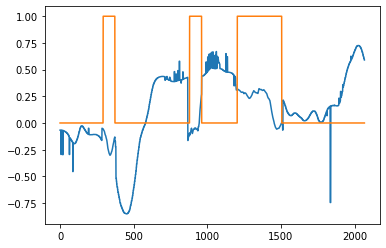

In [21]:
a = drop(cdata[cenario][0]['data'], False)
a['left_OVRHandPrefab_pos_X'].plot()
plt.plot((a['LeftHandTrackingAccuracy'] == 'High')*1.0)

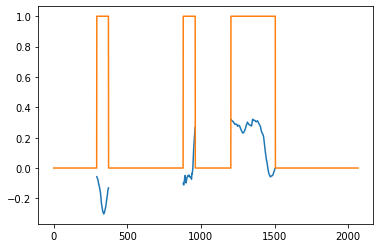

In [22]:
b = rem_low_acc(a, False)
b['left_OVRHandPrefab_pos_X'].plot()
plt.plot(b['LeftHandTrackingAccuracy'])

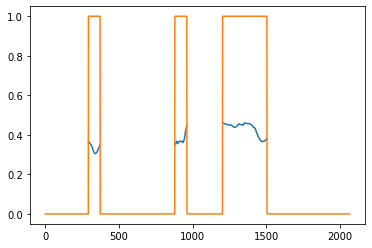

In [23]:
c = norm(b, False)
c['left_OVRHandPrefab_pos_X'].plot()
plt.plot(c['LeftHandTrackingAccuracy'])

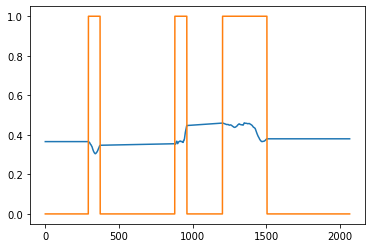

In [24]:
d = interpol(c, False)
d['left_OVRHandPrefab_pos_X'].plot()
plt.plot(d['LeftHandTrackingAccuracy'])

In [25]:
%%time
train = np.array([x['data'] for x in pdata if x['session'] == 1])
test = np.array([x['data'] for x in pdata if x['session'] == 2])

len(train), len(test)

CPU times: user 234 µs, sys: 0 ns, total: 234 µs
Wall time: 252 µs


(48, 48)

In [26]:
%%time

X_train = list()
y_train = list()

X_test = list()
y_test = list()

train = list()
test = list()

for x in tqdm(pdata):
    if x['session'] == 1:
        train.append(
            {
                'label': x['user'],
                'data': list()
            })
        for y in x['data'].unbatch().as_numpy_iterator():
            if not np.isnan(y[0]).any():
                X_train.append(y[0])
                y_train.append(y[1])
                
                train[-1]['data'].append(y[0])
        if len(train[-1]['data']) == 0:
            del train[-1]
    if x['session'] == 2:
        test.append(
            {
                'label': x['user'],
                'data': list()
            })
        for y in x['data'].unbatch().as_numpy_iterator():
            if not np.isnan(y[0]).any():
                X_test.append(y[0])
                y_test.append(y[1])
                
                test[-1]['data'].append(y[0])
            
        if len(test[-1]['data']) == 0:
            del test[-1]
            
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

100%|██████████| 96/96 [00:36<00:00,  2.62it/s]


(57800, 5, 336) (57800,) (37106, 5, 336) (37106,)
CPU times: user 1min 48s, sys: 14.9 s, total: 2min 3s
Wall time: 37 s


Key: 1: 1347
Key: 2: 1583
Key: 3: 8568
Key: 4: 3034
Key: 5: 1960
Key: 6: 3311
Key: 7: 3971
Key: 8: 1407
Key: 9: 1135
Key: 10: 7466
Key: 11: 6494
Key: 12: 1813
Key: 13: 3596
Key: 14: 3260
Key: 15: 2825
Key: 16: 6030


array([<AxesSubplot:ylabel='0'>], dtype=object)

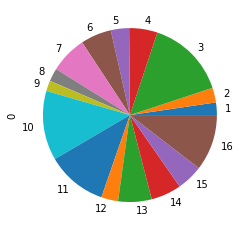

In [27]:
Xy_train = list(zip(X_train, y_train))
Xy_test = list(zip(X_test, y_test))
train_dict = {"1":[], "2":[],"3":[], "4":[], "5":[],"6":[], "7":[], "8":[],"9":[], "10":[], "11":[],"12":[], "13":[], "14":[], "15": [], "16": []}

[train_dict[str(e[1])].append(e[0]) for e in Xy_train]
[print(f'Key: {k}: {len(v)}') for k, v in train_dict.items()]
pd.DataFrame.from_dict({k: len(v) for k, v in train_dict.items()}, orient='index').plot.pie(subplots=True, legend=False)

Key: 1: 790
Key: 2: 59
Key: 3: 4330
Key: 4: 0
Key: 5: 545
Key: 6: 348
Key: 7: 5245
Key: 8: 3558
Key: 9: 2565
Key: 10: 4163
Key: 11: 3654
Key: 12: 2868
Key: 13: 2130
Key: 14: 2360
Key: 15: 2390
Key: 16: 2101


array([<AxesSubplot:ylabel='0'>], dtype=object)

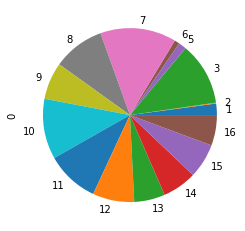

In [28]:
Xy_test = list(zip(X_test, y_test))
test_dict = {"1":[], "2":[],"3":[], "4":[], "5":[],"6":[], "7":[], "8":[],"9":[], "10":[], "11":[],"12":[], "13":[], "14":[], "15": [], "16": []}

[test_dict[str(e[1])].append(e[0]) for e in Xy_test]
[print(f'Key: {k}: {len(v)}') for k, v in test_dict.items()]
pd.DataFrame.from_dict({k: len(v) for k, v in test_dict.items()}, orient='index').plot.pie(subplots=True, legend=False)

In [29]:
%%time

from sklearn.preprocessing import LabelBinarizer


lb = LabelBinarizer()
yy_train = lb.fit_transform(y_train)
yy_test = lb.transform(y_test)

CPU times: user 355 ms, sys: 13 ms, total: 368 ms
Wall time: 367 ms


In [30]:
for e in test:
    e['label'] = lb.transform([e['label']])
    e['data'] = np.array(e['data'])

        
for e in train:
    e['label'] = lb.transform([e['label']])
    e['data'] = np.array(e['data'])

In [31]:
print(X_train.shape)
print(yy_train.shape)
print(X_test.shape)
print(yy_test.shape)

(57800, 5, 336)
(57800, 16)
(37106, 5, 336)
(37106, 16)


# Building Model

In [32]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

def build_model(shape, classes):
    model = Sequential()
    
    ncount = shape[0]*shape[1]
    
    model.add(Flatten(input_shape=shape, name='flatten'))
    
    model.add(Dropout(drop_count, name=f'dropout_{drop_count*100}'))
    model.add(BatchNormalization(name='batchNorm'))
    
    for i in range(2,layer_count+2):
        neurons = int(ncount/pow(dense_steps,i))
        if neurons <= classes:
            break
        model.add(Dropout(drop_count*i, name=f'HiddenDropout_{drop_count*i*100:.0f}'))
        model.add(Dense(neurons, activation='relu', 
                        kernel_regularizer=l2(0.001), name=f'Hidden_{i}')
                 )
    
    model.add(Dense(classes, activation='softmax', name='Output'))
    
    model.compile(
        optimizer=Adam(),
        loss="categorical_crossentropy", 
        metrics=["acc"],
    )
    
    model.summary()
    return model

In [33]:
checkpoint_file = './goat.weights'

def train_model(X_train, y_train, X_test, y_test):
    model = build_model(X_train[0].shape, 16)
    
    # Create a callback that saves the model's weights
    model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='loss', 
			save_best_only=True)
    
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=0.0001)

    callbacks = [model_checkpoint, reduce_lr]
    
    history = model.fit(X_train, 
                        y_train,
                        epochs=epoch,
                        batch_size=32,
                        verbose=2,
                        validation_data=(X_test, y_test),
                        callbacks=callbacks
             )
    
    model.load_weights(checkpoint_path)
    return model, history

In [34]:
%%time

if not os.path.isdir(checkpoint_dir) or create_new:
    tf.keras.backend.clear_session()
    model, history = train_model(np.array(X_train), np.array(yy_train), np.array(X_test), np.array(yy_test))
else:
    print("Loaded weights...")
    model = build_model(X_train[0].shape, 16)
    model.load_weights(checkpoint_path)

Loaded weights...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1680)              0         
_________________________________________________________________
dropout_10.0 (Dropout)       (None, 1680)              0         
_________________________________________________________________
batchNorm (BatchNormalizatio (None, 1680)              6720      
_________________________________________________________________
HiddenDropout_20 (Dropout)   (None, 1680)              0         
_________________________________________________________________
Hidden_2 (Dense)             (None, 186)               312666    
_________________________________________________________________
HiddenDropout_30 (Dropout)   (None, 186)               0         
_________________________________________________________________
Hidden_3 (Dense)             (None, 62

# Eval

In [35]:
def predict(model, entry):
    p_dict = dict()
    predictions = np.argmax(model.predict(entry), axis=-1)
    for p in predictions:
        if p in p_dict:
            p_dict[p] += 1
        else:
            p_dict[p] = 1
    prediction = max(p_dict, key=p_dict.get)
    return prediction+1

In [36]:
%%time

ltest = [lb.inverse_transform(e['label'])[0] for e in test]
ptest = [predict(model, e['data']) for e in test]

len(ltest), len(ptest)

CPU times: user 3.36 s, sys: 529 ms, total: 3.89 s
Wall time: 2.95 s


(43, 43)

In [37]:
%%time

ltrain = [lb.inverse_transform(e['label'])[0] for e in train]
ptrain = [predict(model, e['data']) for e in train]


len(ltrain), len(ptrain)

CPU times: user 3.85 s, sys: 448 ms, total: 4.3 s
Wall time: 2.99 s


(47, 47)

In [38]:
set(ltrain), set(ltest)

({1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16},
 {1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16})

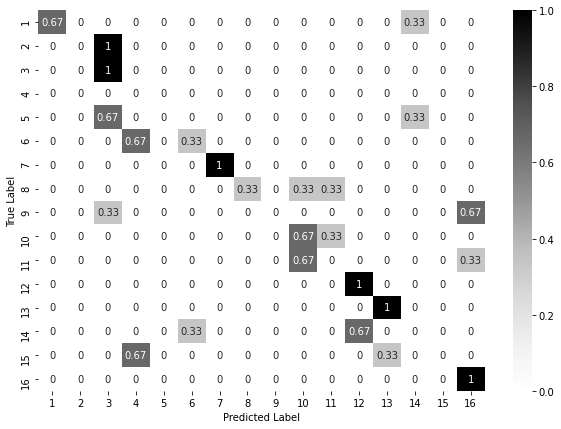

              precision    recall  f1-score   support

           1       1.00      0.67      0.80         3
           2       0.00      0.00      0.00         1
           3       0.43      1.00      0.60         3
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         3
           6       0.50      0.33      0.40         3
           7       1.00      1.00      1.00         3
           8       1.00      0.33      0.50         3
           9       0.00      0.00      0.00         3
          10       0.40      0.67      0.50         3
          11       0.00      0.00      0.00         3
          12       0.60      1.00      0.75         3
          13       0.75      1.00      0.86         3
          14       0.00      0.00      0.00         3
          15       0.00      0.00      0.00         3
          16       0.50      1.00      0.67         3

    accuracy                           0.49        43
   macro avg       0.39   

In [39]:
%%time

from sklearn.metrics import confusion_matrix
import seaborn as sn

from sklearn.metrics import classification_report

set_digits = set(ltrain)

train_cm = confusion_matrix(ltrain, ptrain, labels=list(set_digits), normalize='true')
test_cm = confusion_matrix(ltest, ptest, labels=list(set_digits), normalize='true')

df_cm = pd.DataFrame(test_cm, index=set_digits, columns=set_digits)
plt.figure(figsize = (10,7))
sn_plot = sn.heatmap(df_cm, annot=True, cmap="Greys")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

print(classification_report(ltest, ptest, zero_division=0))

In [40]:
def plot_keras_history(history, name='', acc='acc'):
    """Plots keras history."""
    import matplotlib.pyplot as plt

    training_acc = history.history[acc]
    validation_acc = history.history['val_' + acc]
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(training_acc))

    plt.ylim(0, 1)
    plt.plot(epochs, training_acc, 'tab:blue', label='Training acc')
    plt.plot(epochs, validation_acc, 'tab:orange', label='Validation acc')
    plt.title('Training and validation accuracy  ' + name)
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'tab:green', label='Training loss')
    plt.plot(epochs, val_loss, 'tab:red', label='Validation loss')
    plt.title('Training and validation loss  ' + name)
    plt.legend()
    plt.show()
    plt.close()
if 'history' in locals():
    plot_keras_history(history)

In [41]:
print(f'Scenario: {cenario}')
print(f'Window Size: {win_sz}')
print(f'Strides: {stride_sz}')
print(f'Epochs: {epoch}')
print(f'HiddenL Count: {layer_count}')
print(f'Neuron Factor: {dense_steps}')
print(f'Drop Factor: {drop_count}')

Scenario: SYN
Window Size: 5
Strides: 1
Epochs: 50
HiddenL Count: 3
Neuron Factor: 3
Drop Factor: 0.1


In [42]:
exit()